In [2]:
from numba import jit, njit, prange
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm 
from multiprocessing import Pool

## parameter setup

zeta is setup later in the solver

In [2]:
# S_space = np.arange(50)
# XI_space = np.arange(20)
# A_space = np.arange(50)
# Z_space = np.arange(500)
# W_space = np.arange(100)

p, c, h = 4, 2, 1
T = 10



S_space = np.arange(5)
XI_space = np.arange(5)
A_space = np.arange(5)

d_max = XI_space.max()
w_bias = -T*d_max*(p+c+h)

Z_space = np.arange((-w_bias)*2)
W_space = np.arange((-w_bias)*2)+w_bias

# prob = np.ones(len(XI_space))*1/len(XI_space)
prob = stats.norm.pdf(XI_space, int(max(XI_space)/2)+1, 2)
prob = prob/prob.sum()



## prob distribution

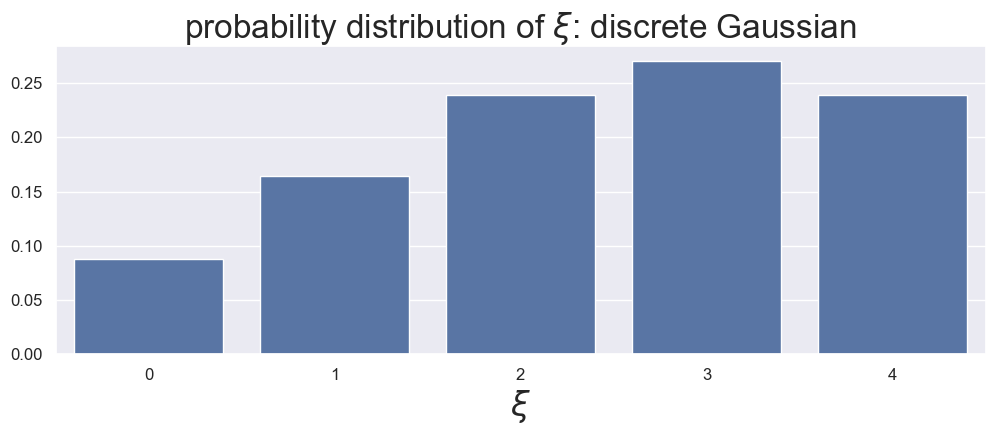

In [3]:
sns.set_theme(style="ticks")
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
sns.barplot(x=XI_space,y=prob, color='b', ax=ax)
ax.set_xlabel(r'$\xi$')
# ax.set_ylabel(r'')
ax.set_title(r'probability distribution of $\xi$: discrete Gaussian')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

## reward function

In [4]:
@jit(nopython=True, parallel=True)
def R_t(S_space, A_space, Xi_space): # Function is compiled and runs in machine code
    res = np.zeros(shape=(len(S_space), len(A_space), len(Xi_space)))
    # for s in S_space:
    for s in prange(len(S_space)):
        for a in A_space:
            for xi in Xi_space:
                res[s,a,xi] = p*min(s+a,xi) - c*a - h*min(max(s+a-xi,0), max(S_space))
    return res 

r_t = R_t(S_space, A_space, XI_space)
r_t

array([[[  0.,   0.,   0.,   0.,   0.],
        [ -3.,   2.,   2.,   2.,   2.],
        [ -6.,  -1.,   4.,   4.,   4.],
        [ -9.,  -4.,   1.,   6.,   6.],
        [-12.,  -7.,  -2.,   3.,   8.]],

       [[ -1.,   4.,   4.,   4.,   4.],
        [ -4.,   1.,   6.,   6.,   6.],
        [ -7.,  -2.,   3.,   8.,   8.],
        [-10.,  -5.,   0.,   5.,  10.],
        [-12.,  -8.,  -3.,   2.,   7.]],

       [[ -2.,   3.,   8.,   8.,   8.],
        [ -5.,   0.,   5.,  10.,  10.],
        [ -8.,  -3.,   2.,   7.,  12.],
        [-10.,  -6.,  -1.,   4.,   9.],
        [-12.,  -8.,  -4.,   1.,   6.]],

       [[ -3.,   2.,   7.,  12.,  12.],
        [ -6.,  -1.,   4.,   9.,  14.],
        [ -8.,  -4.,   1.,   6.,  11.],
        [-10.,  -6.,  -2.,   3.,   8.],
        [-12.,  -8.,  -4.,   0.,   5.]],

       [[ -4.,   1.,   6.,  11.,  16.],
        [ -6.,  -2.,   3.,   8.,  13.],
        [ -8.,  -4.,   0.,   5.,  10.],
        [-10.,  -6.,  -2.,   2.,   7.],
        [-12.,  -8.,  -4.,   0.,

# RN

solver is used to compute optimal value function and action at each time

In [5]:
@jit(nopython=True, parallel=True)
def solver_t(r, v, prob, S_space, A_space, Xi_space):
    r_sa = np.zeros(shape=(len(S_space), len(A_space)))
    # for s in S_space:
    for s in prange(len(S_space)):
        for a in A_space:
            s_next = np.clip(s+a-Xi_space, a_min=min(S_space), a_max=max(S_space))

            v_next = np.array([ v[int(ss)] for ss in s_next ])
            r_sa[s,a] = np.dot(r[s,a] + v_next, prob)   
    
    opt_a = [ rs.argmax() for rs in r_sa ]
    opt_r = [ rs.max() for rs in r_sa ]
    return opt_a, opt_r

In [6]:
value_functions_RN = {T: np.zeros(len(S_space))}
optimal_actions_RN = {}

solve MDP from T-1 to 0

In [7]:
r_t = R_t(S_space, A_space, XI_space)
for t in range(T-1, -1, -1):
    optimal_actions_RN[t], value_functions_RN[t] = solver_t(r_t, value_functions_RN[t+1], prob, S_space, A_space, XI_space)

/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function 'solver_t'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/c8/bhktjw_92pbd_b3n7f7j29xh0000gn/T/ipykernel_7687/753573004.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function '__numba_parfor_gufunc_0x157502cb0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-f

In [8]:
# optimal_actions
action_matrix = np.array([ optimal_actions_RN[t] for t in optimal_actions_RN ])
action_df = pd.DataFrame(action_matrix)
action_df

,0,1,2,3,4
0,2,1,0,0,0
1,3,2,1,0,0
2,3,2,1,0,0
3,3,2,1,0,0
4,3,2,1,0,0
5,3,2,1,0,0
6,3,2,1,0,0
7,3,2,1,0,0
8,3,2,1,0,0
9,3,2,1,0,0


Text(0.5, 1.0, 'RN optimal actions for each state in $\\mathbb{S}$')

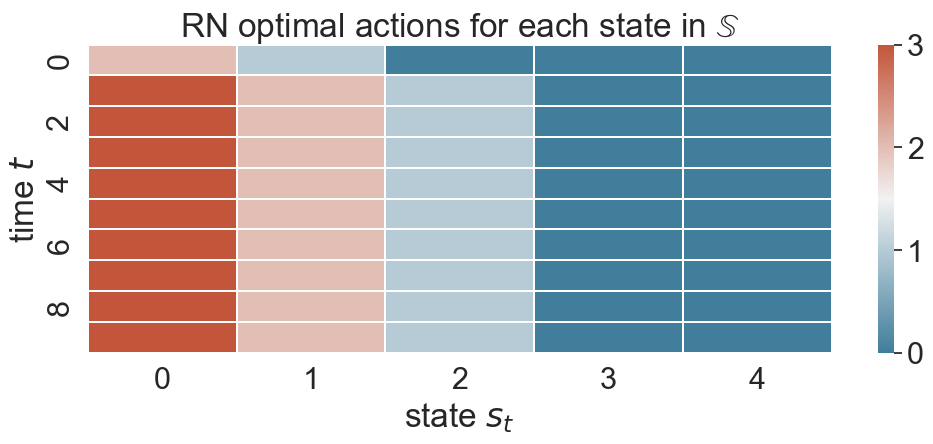

In [9]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(action_df, cmap=cmap, linewidths=.1, ax=ax)
ax.set_xlabel(r'state $s_t$')
ax.set_ylabel(r'time $t$')
ax.set_title(r'RN optimal actions for each state in $\mathbb{S}$')

Text(0.5, 1.0, 'RN value functions for each state in $\\mathbb{S}$')

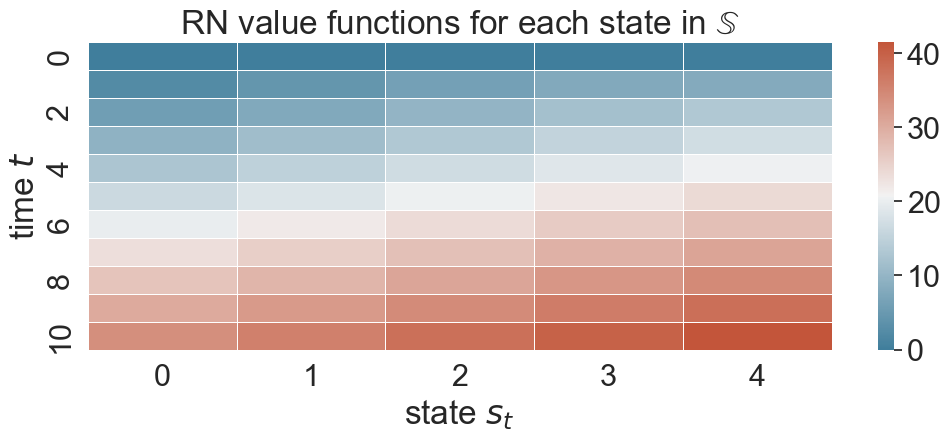

In [10]:
value_matrix = np.array([ value_functions_RN[t] for t in value_functions_RN ])
value_df = pd.DataFrame(value_matrix)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(value_df, cmap=cmap, linewidths=.5, ax=ax)
ax.set_xlabel(r'state $s_t$')
ax.set_ylabel(r'time $t$')
ax.set_title(r'RN value functions for each state in $\mathbb{S}$')

# CVaR

In [11]:
@jit(nopython=True)
def CVAR(x, p, alpha):
    ita_array = np.linspace(0,1000, 100000)
    ita_x = np.zeros(shape=(len(ita_array), len(x)))
    for ita_idx, ita in enumerate(ita_array):
        ita_x[ita_idx, :] = np.clip(ita-x, a_min=0, a_max=np.inf)

    return np.max(ita_array - ita_x.dot(p)/alpha)

In [12]:
VAR_alpha = 0.6

@jit(nopython=True, parallel=True)
def solver_cvar_t(r, v, prob, S_space, A_space, XI_space):
    r_sa = np.zeros(shape=(len(S_space), len(A_space)))
    # for s in S_space:
    for s in prange(len(S_space)):
        for a in A_space:
            s_next = np.clip(s+a-XI_space, a_min=0, a_max=max(S_space))
            v_next = np.array([ v[int(ss)] for ss in s_next ])

            r_sa[s,a] = CVAR(r[s,a] + v_next, prob, VAR_alpha)            
    
    opt_a = [ rs.argmax() for rs in r_sa ]
    opt_r = [ rs.max() for rs in r_sa ]
    return opt_a, opt_r

In [13]:
value_functions_cvar = {T: np.zeros(len(S_space))}
optimal_actions_cvar = {}

In [14]:
r_t = R_t(S_space, A_space, XI_space)
for t in tqdm(range(T-1, -1, -1)):    
    optimal_actions_cvar[t], value_functions_cvar[t] = solver_cvar_t(r_t, value_functions_cvar[t+1], prob, S_space, A_space, XI_space)

 10%|█         | 1/10 [00:01<00:13,  1.47s/it]/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function 'solver_cvar_t'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/c8/bhktjw_92pbd_b3n7f7j29xh0000gn/T/ipykernel_7687/1495136845.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function '__numba_parfor_gufunc_0x168792290'.

For more information visit https://numba.readthedocs.io/en/stable/re

In [15]:
# optimal_actions
action_matrix = np.array([ optimal_actions_cvar[t] for t in optimal_actions_cvar ])
action_df = pd.DataFrame(action_matrix)
action_df

,0,1,2,3,4
0,1,0,0,0,0
1,2,1,0,0,0
2,2,1,0,0,0
3,2,1,0,0,0
4,2,1,0,0,0
5,2,1,0,0,0
6,2,1,0,0,0
7,2,1,0,0,0
8,2,1,0,0,0
9,2,1,0,0,0


Text(0.5, 1.0, 'CVaR@0.6: optimal actions for each state in $\\mathbb{S}$')

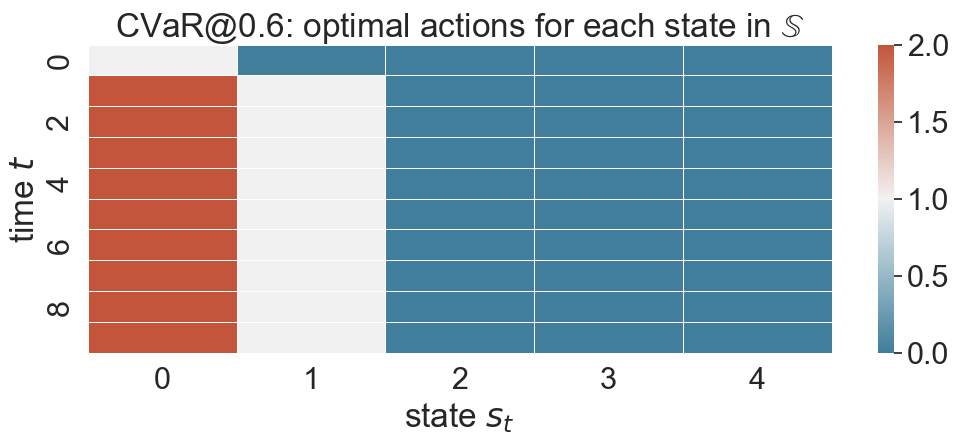

In [16]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(action_df, cmap=cmap, linewidths=.5, ax=ax)
ax.set_xlabel(r'state $s_t$')
ax.set_ylabel(r'time $t$')
ax.set_title(f'CVaR@{VAR_alpha}: optimal actions for each state in '+r'$\mathbb{S}$')

In [17]:
# optimal_actions
value_matrix = np.array([ value_functions_cvar[t] for t in value_functions_cvar ])
value_df = pd.DataFrame(value_matrix)
value_df

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.268031,3.268018,5.168563,5.079446,4.079496
2,3.553288,5.553275,7.553261,8.766747,8.717470
3,5.852586,7.852598,9.852610,11.285278,11.770171
4,8.152319,10.152331,12.152342,13.616825,14.239871
5,10.452220,12.452232,14.452244,15.921268,16.573240
6,12.752192,14.752204,16.752215,18.221857,18.879305
7,15.052194,17.052205,19.052217,20.521928,21.180347
8,17.352208,19.352219,21.352231,22.821944,23.480523
9,19.652227,21.652239,23.652250,25.121960,25.780563


Text(0.5, 1.0, 'CVaR@0.6: value functions for each state in $\\mathbb{S}$')

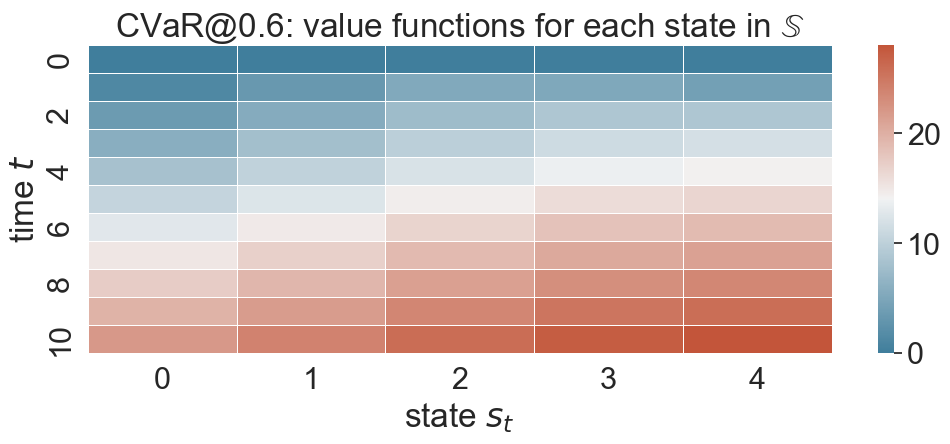

In [18]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(value_df, cmap=cmap, linewidths=.5, ax=ax)
ax.set_xlabel(r'state $s_t$')
ax.set_ylabel(r'time $t$')
ax.set_title(f'CVaR@{VAR_alpha}: value functions for each state in '+r'$\mathbb{S}$')

# rollout

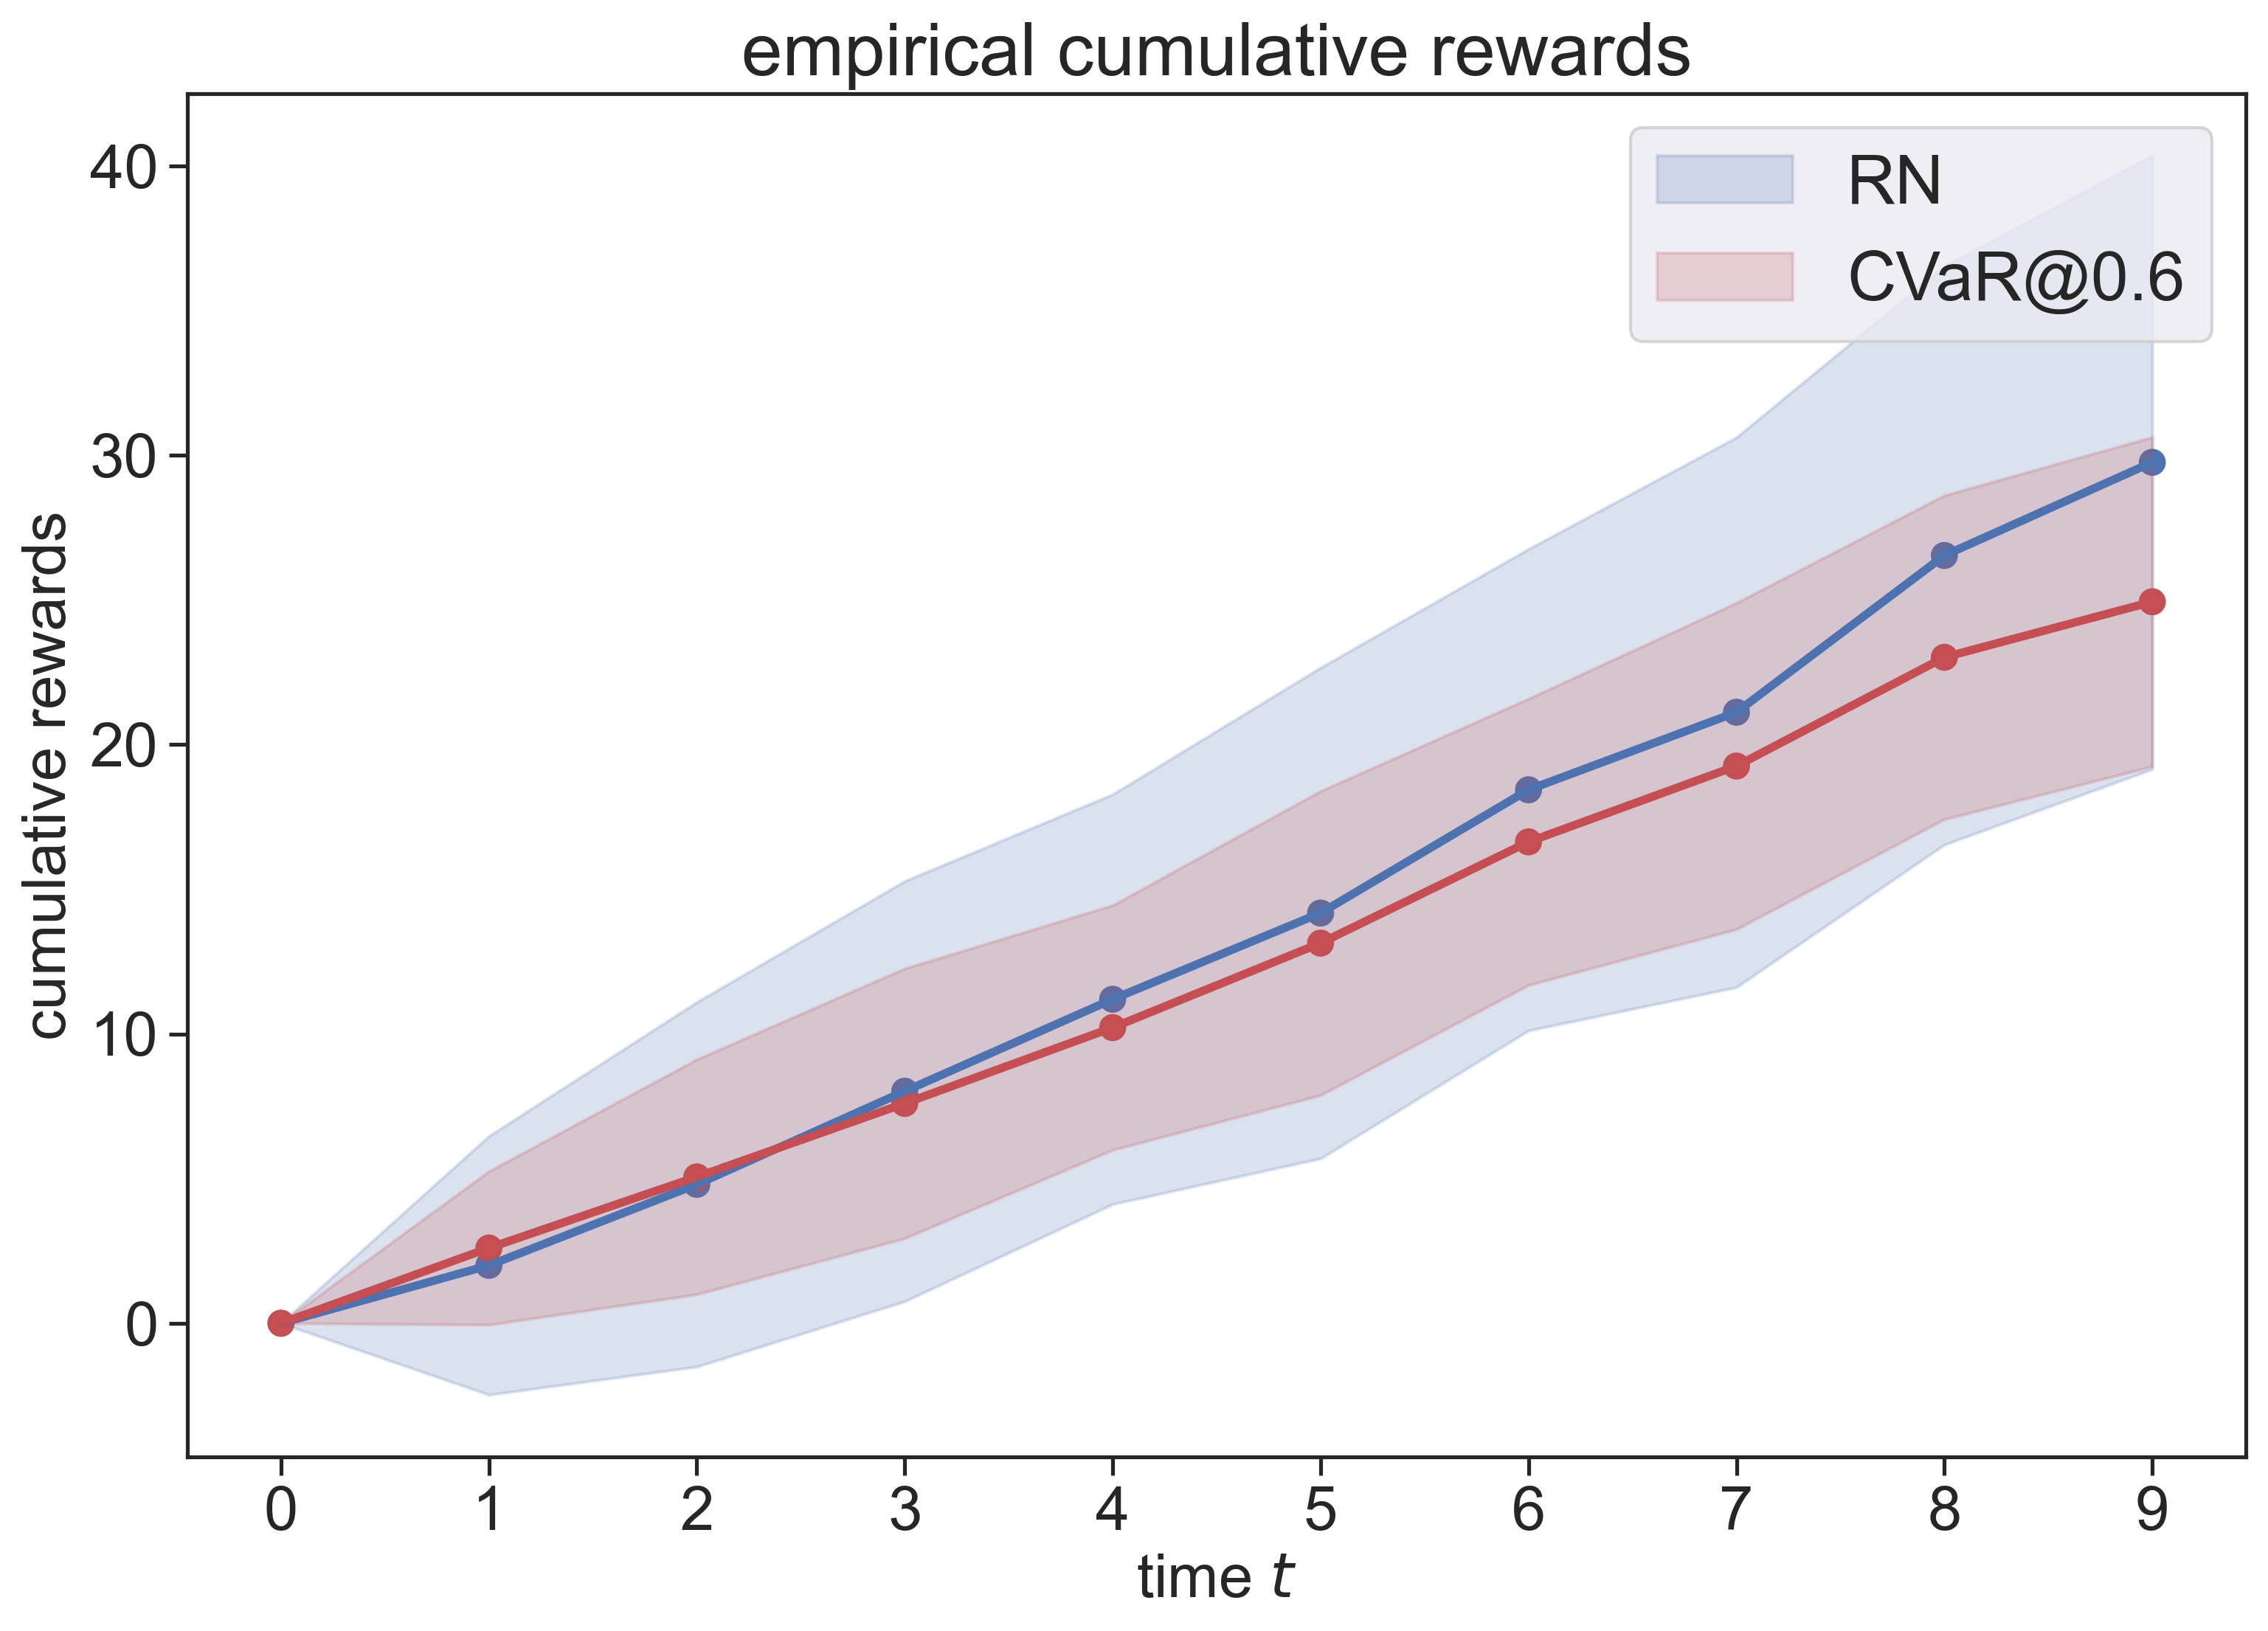

In [19]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set(font_scale=2)


CNT = 50
# generate random samples
np.random.seed(0)
s_rn_history = np.zeros(shape=(CNT,T))
a_rn_history = np.zeros(shape=(CNT,T))
r_rn_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_rn_history = np.random.choice(XI_space, T, p=prob)

    for t in range(1,T):
        s_t = s_rn_history[cnt, t]
        a_t = optimal_actions_RN[t][int(s_t)]
        r_rn_history[cnt, t] = r_t[int(s_t), a_t, xi_rn_history[t]]
        s_next = np.clip(s_t+a_t-xi_rn_history[t], a_min=0, a_max=max(S_space))
        a_rn_history[cnt, t] = a_t
        if t+1 <= T-1:
            s_rn_history[cnt, t+1] = s_next
            
r_rn_history_cumsum = r_rn_history.cumsum(axis=1)
r_rn_history_mean = r_rn_history_cumsum.mean(axis=0)
r_rn_history_std = r_rn_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_rn_history_mean, ax=ax, color='b')
ax.fill_between(x=np.arange(T), y1=r_rn_history_mean-r_rn_history_std, y2=r_rn_history_mean+r_rn_history_std, 
                color='b', alpha=0.2, label='RN')


np.random.seed(0)
s_cvar_history = np.zeros(shape=(CNT,T))
a_cvar_history = np.zeros(shape=(CNT,T))
r_cvar_history = np.zeros(shape=(CNT,T))
for cnt in range(CNT):
    xi_cvar_history = np.random.choice(XI_space, T, p=prob)

    for t in range(1,T):
        s_t = s_cvar_history[cnt, t]
        a_t = optimal_actions_cvar[t][int(s_t)]
        r_cvar_history[cnt, t] = r_t[int(s_t), a_t, xi_cvar_history[t]]
        s_next = np.clip(s_t+a_t-xi_cvar_history[t], a_min=0, a_max=max(S_space))
        a_cvar_history[cnt, t] = a_t
        if t+1 <= T-1:
            s_cvar_history[cnt, t+1] = s_next
            
r_cvar_history_cumsum = r_cvar_history.cumsum(axis=1)
r_cvar_history_mean = r_cvar_history_cumsum.mean(axis=0)
r_cvar_history_std = r_cvar_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_cvar_history_mean, ax=ax, color='r')
ax.fill_between(x=np.arange(T), y1=r_cvar_history_mean-r_cvar_history_std, y2=r_cvar_history_mean+r_cvar_history_std, 
                color='r', alpha=0.2, label=f'CVaR@{VAR_alpha}')


ax.set_title('empirical cumulative rewards')
ax.legend()
ax.set_xlabel(r'time $t$', fontsize=20)
ax.set_ylabel('cumulative rewards', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# ax.set_yticks(fontsize=20)


## Standard capital requirement

In [20]:
# w_{t+1} = w_t - z_t
# A = E[R(s_t,a_t)] + z_t > zeta
zeta = 0

@jit(nopython=True, parallel=True)
def solver_scr_wT(r, prob, S_space, A_space, Z_space, W_space, Xi_space):
    w_bias = min(W_space)
    SW_space = np.arange(len(S_space)*len(W_space))
    AZ_space = np.arange(len(A_space)*len(Z_space))   
    
    r_sa = np.zeros(shape=(len(SW_space), len(AZ_space)))
    # for sw in SW_space:
    for sw in prange(len(SW_space)):
        for az in AZ_space:

            s, w = sw//len(W_space), sw%len(W_space)+w_bias
            z, a = az//len(A_space), az%len(A_space)
            
            exp_z = np.dot(r[s,a], prob)

            if exp_z+z >= zeta and w+exp_z-z >= 0:
                r_sa[sw,az] = 0
            else:
                r_sa[sw,az] = np.inf
                
    opt_a = [ rs.argmin() for rs in r_sa ]
    opt_r = [ rs.min() for rs in r_sa ]
    return opt_a, opt_r


@jit(nopython=True, parallel=True)
def solver_scr_wt(r, v, prob, S_space, A_space, Z_space, W_space, Xi_space):
    w_bias = min(W_space)
    SW_space = np.arange(len(S_space)*len(W_space))
    AZ_space = np.arange(len(A_space)*len(Z_space))   
    
    r_sa = np.zeros(shape=(len(SW_space), len(AZ_space)))
    # for sw in SW_space:
    for sw in prange(len(SW_space)):
        for az in AZ_space:
            s, w = sw//len(W_space), sw%len(W_space)+w_bias
            z, a = az//len(A_space), az%len(A_space)
            
            exp_z = np.dot(r[s,a], prob)

            if exp_z+z >= zeta:
                w_next = min(max(w-z, w_bias), max(W_space))
                s_next = np.clip(s+a-Xi_space, a_min=min(S_space), a_max=max(S_space))

                sw_next = s_next*len(W_space)+(w_next-w_bias)
                v_next = np.array([ v[int(ssww)] for ssww in sw_next ])

                r_sa[sw,az] = np.dot(v_next, prob)
            else:
                r_sa[sw,az] = np.inf
                
    opt_a = [ rs.argmin() for rs in r_sa ]
    opt_r = [ rs.min() for rs in r_sa ]
    return opt_a, opt_r


@jit(nopython=True, parallel=True)
def solver_scr_w0(r, v, prob, S_space, A_space, Z_space, W_space, Xi_space):
    w_bias = min(W_space)
    AZW_space = np.arange(len(A_space)*len(Z_space)*len(W_space))   
    
    r_sa = np.zeros(shape=(len(S_space), len(AZW_space)))
    # for s in S_space:
    for s in prange(len(S_space)):
        for azw in AZW_space:
            w, az = azw//(len(A_space)*len(Z_space))+w_bias, azw%(len(A_space)*len(Z_space))
            z, a = az//len(A_space), az%len(A_space)
            
            exp_z = np.dot(r[s,a], prob)

            if exp_z+z >= zeta:
                w_next = min(max(w-z, w_bias), max(W_space))
                s_next = np.clip(s+a-Xi_space, a_min=min(S_space), a_max=max(S_space))
                sw_next = s_next*len(W_space)+(w_next-w_bias)
                v_next = np.array([ v[int(ssww)] for ssww in sw_next ])

                r_sa[s,azw] = w+np.dot(v_next, prob)
            else:
                r_sa[s,azw] = np.inf
                
    opt_a = [ rs.argmin() for rs in r_sa ]
    opt_r = [ rs.min() for rs in r_sa ]
    return opt_a, opt_r

In [21]:
value_functions_scr = {}
optimal_actions_scr = {}

In [22]:
r_t = R_t(S_space, A_space, XI_space)

optimal_actions_scr[T], value_functions_scr[T] = solver_scr_wT(r_t, prob, S_space, A_space, Z_space, W_space, XI_space)

for t in tqdm(range(T-1, 0, -1)):    
    optimal_actions_scr[t], value_functions_scr[t] = solver_scr_wt(r_t, value_functions_scr[t+1], prob, S_space, A_space, Z_space, W_space, XI_space)
    
   
optimal_actions_scr[0], value_functions_scr[0] = solver_scr_w0(r_t, value_functions_scr[1], prob, S_space, A_space, Z_space, W_space, XI_space)

  0%|          | 0/9 [00:00<?, ?it/s]/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function 'solver_scr_wt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/c8/bhktjw_92pbd_b3n7f7j29xh0000gn/T/ipykernel_7687/1846408983.py", line 31:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function '__numba_parfor_gufunc_0x2a3ba03d0'.

For more information visit https://numba.readthedocs.io/en/stable/reference/

Text(0.5, 1.0, 'optimal actions for each state in $\\mathbb{S}$')

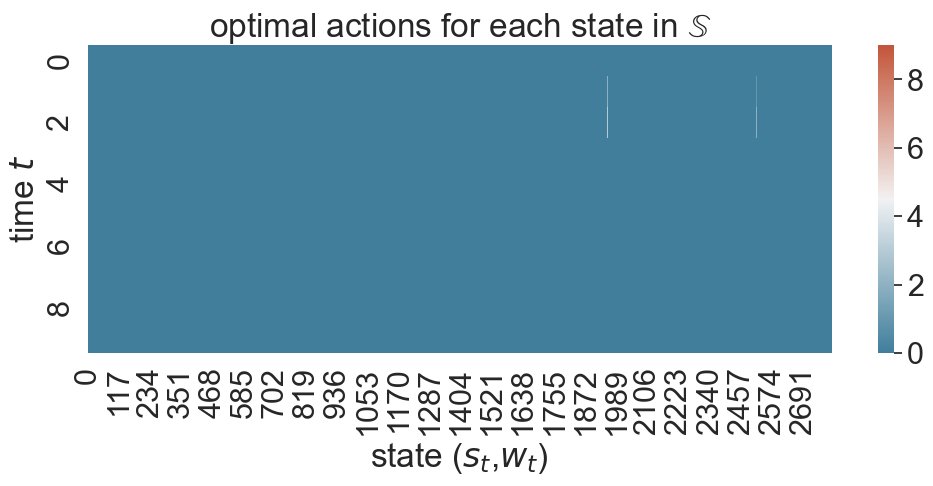

In [50]:
action_matrix = np.array([ optimal_actions_scr[t] for t in optimal_actions_scr if t!=0 ])
action_df = pd.DataFrame(action_matrix)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(action_df, cmap=cmap, ax=ax)
ax.set_xlabel(r'state ($s_t$,$w_t$)')
ax.set_ylabel(r'time $t$')
ax.set_title(f'optimal actions for each state in '+r'$\mathbb{S}$')

In [24]:
value_matrix = np.array([ value_functions_scr[t] for t in value_functions_scr if t!=0 ])
value_df = pd.DataFrame(value_matrix)
value_df

,0,1,2,3,4,5,6,7,8,9,...,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'value functions for each state in $\\mathbb{S}$')

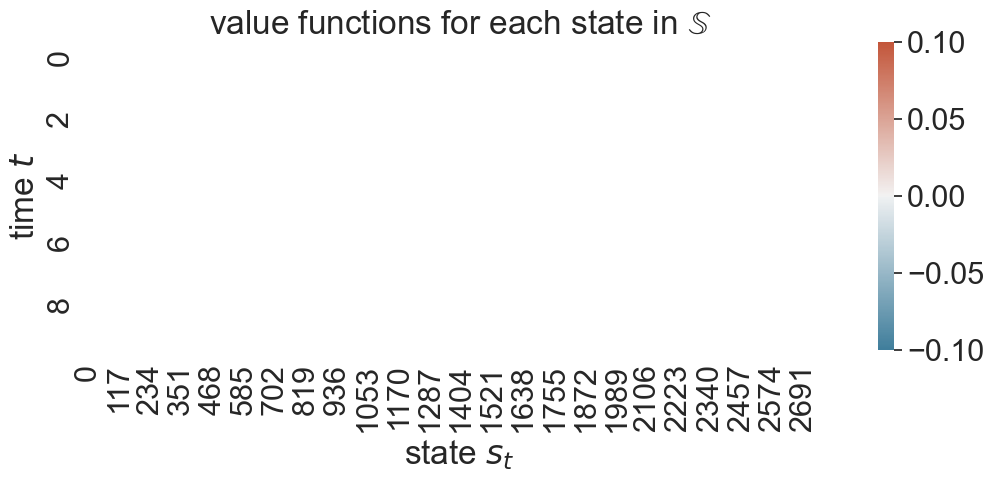

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(value_df, cmap=cmap, linewidths=.5, ax=ax)
ax.set_xlabel(r'state $s_t$')
ax.set_ylabel(r'time $t$')
ax.set_title(f'value functions for each state in '+r'$\mathbb{S}$')

## Wealth reserve

In [26]:
# w_{t+1} = w_t + z_t
# A = w_t + E[R_t(s_t,a_t)] + z_t >= zeta
zeta = 10

@jit(nopython=True, parallel=True)
def solver_wr_wt(r, v, prob, S_space, A_space, Z_space, W_space, Xi_space):
    SW_space = np.arange(len(S_space)*len(W_space))
    AZ_space = np.arange(len(A_space)*len(Z_space))   
    
    r_sa = np.zeros(shape=(len(SW_space), len(AZ_space)))
    # for sw in SW_space:
    for sw in prange(len(SW_space)):
        for az in AZ_space:
            s, w = sw//len(W_space), sw%len(W_space)+w_bias
            z, a = az//len(A_space), az%len(A_space)
            
            exp_z = np.dot(r[s,a], prob)

            if w+exp_z+z >= zeta:
                w_next = np.clip(w+r[s,a], a_min=min(W_space), a_max=max(W_space))
                s_next = np.clip(s+a-Xi_space, a_min=min(S_space), a_max=max(S_space))

                sw_next = s_next*len(W_space)+(w_next-w_bias)
                v_next = np.array([ v[int(ssww)] for ssww in sw_next ])

                r_sa[sw,az] = z+np.dot(v_next, prob)
            else:
                r_sa[sw,az] = np.inf
                
    opt_a = [ rs.argmin() for rs in r_sa ]
    opt_r = [ rs.min() for rs in r_sa ]
    return opt_a, opt_r

In [27]:
start = time.time()
r_t=R_t(S_space, A_space, XI_space)
print(f'run time: {time.time()-start}')

v_T = np.zeros(len(S_space)*len(W_space))
a_t, v_t = solver_wr_wt(r_t, v_T, prob, S_space, A_space, Z_space, W_space, XI_space)  

run time: 0.0002791881561279297


In [28]:
value_functions_wr = {T: np.zeros(len(S_space)*len(W_space))}
optimal_actions_wr = {}

In [29]:
for t in tqdm(range(T-1, -1, -1)):    
    optimal_actions_wr[t], value_functions_wr[t] = solver_wr_wt(r_t, value_functions_wr[t+1], prob, S_space, A_space, Z_space, W_space, XI_space)

 10%|█         | 1/10 [00:00<00:06,  1.37it/s]/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function 'solver_wr_wt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/c8/bhktjw_92pbd_b3n7f7j29xh0000gn/T/ipykernel_7687/1720495599.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function '__numba_parfor_gufunc_0x2aa2eb490'.

For more information visit https://numba.readthedocs.io/en/stable/ref

Text(0.5, 1.0, 'optimal actions for each state in $\\mathbb{S}$')

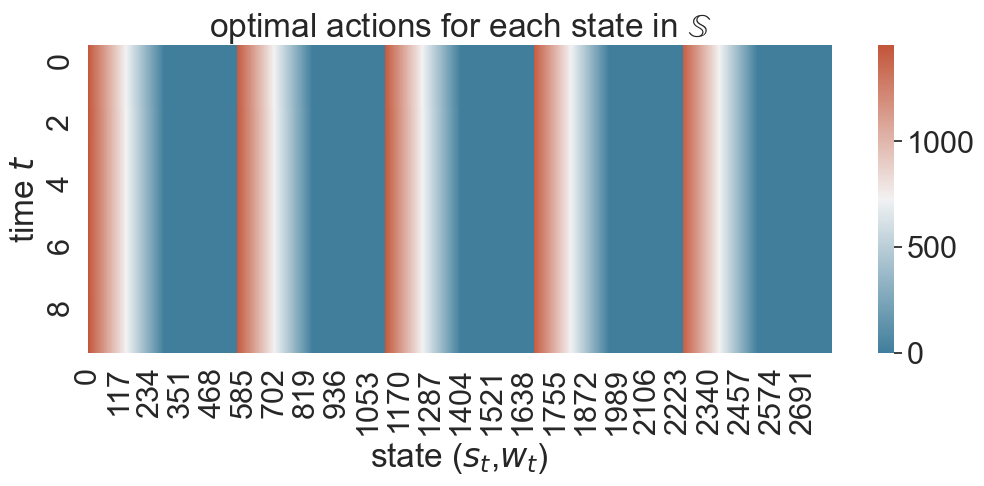

In [52]:
action_matrix = np.array([ optimal_actions_wr[t] for t in optimal_actions_wr ])
action_df = pd.DataFrame(action_matrix)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(action_df, cmap=cmap, ax=ax)
ax.set_xlabel(r'state ($s_t$,$w_t$)')
ax.set_ylabel(r'time $t$')
ax.set_title(f'optimal actions for each state in '+r'$\mathbb{S}$')

In [31]:
value_matrix = np.array([ value_functions_wr[t] for t in value_functions_wr ])
value_df = pd.DataFrame(value_matrix)
value_df

,0,1,2,3,4,5,6,7,8,9,...,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,288.000000,287.000000,286.000000,285.000000,284.000000,283.000000,282.000000,281.000000,280.000000,279.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,572.132306,570.384238,568.636169,566.755794,564.843629,562.931464,561.019298,559.019298,557.019298,555.019298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,851.345195,849.350340,847.092204,844.617038,842.120901,839.310983,836.501066,833.676735,830.852405,828.028074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1126.866352,1124.431794,1121.953236,1118.803783,1115.654331,1112.250124,1108.590692,1104.884865,1101.179038,1097.473211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1398.949332,1396.074472,1393.120810,1389.354362,1385.526976,1381.609617,1377.187853,1372.591796,1367.995739,1363.399682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1667.477018,1664.183359,1660.752961,1656.387258,1651.901123,1647.265378,1642.277630,1636.790755,1631.303879,1625.817004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1932.446447,1928.786970,1924.879635,1919.865472,1914.767266,1909.413021,1903.858427,1897.480756,1891.103085,1884.725414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2193.907424,2189.881901,2185.497637,2179.834997,2174.124521,2168.051796,2161.930309,2154.661872,2147.393436,2140.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2451.859531,2447.467956,2442.606779,2436.295681,2429.972941,2423.181756,2416.390570,2408.334212,2400.175032,2392.015852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cash Order Only

In [32]:
# w_{t+1} = w_t + r_t
# A = c*a_t <= w_t + zeta
zeta = 10

@jit(nopython=True, parallel=True)
def solver_co_wt(r, v, prob, S_space, A_space, W_space, Xi_space):
    w_bias = min(W_space)
    SW_space = np.arange(len(S_space)*len(W_space))
    
    r_sa = np.zeros(shape=(len(SW_space), len(A_space)))
    # for sw in SW_space:
    for sw in prange(len(SW_space)):
        for a in A_space:
            s, w = sw//len(W_space), sw%len(W_space)+w_bias
            
            if c*a <= w + zeta:
                w_next = np.clip(w+r[s,a], a_min=min(W_space), a_max=max(W_space))
                s_next = np.clip(s+a-Xi_space, a_min=min(S_space), a_max=max(S_space))

                sw_next = s_next*len(W_space)+(w_next-w_bias)
                v_next = np.array([ v[int(ssww)] for ssww in sw_next ])

                r_sa[sw,a] = np.dot(r[s,a]+v_next, prob)
            else:
                r_sa[sw,a] = -np.inf
                
    opt_a = [ rs.argmax() for rs in r_sa ]
    opt_r = [ rs.max() for rs in r_sa ]
    return opt_a, opt_r

In [33]:
value_functions_co = {T: np.zeros(len(S_space)*len(W_space))}
optimal_actions_co = {}

In [34]:
for t in tqdm(range(T-1, -1, -1)):    
    optimal_actions_co[t], value_functions_co[t] = solver_co_wt(r_t, value_functions_co[t+1], prob, S_space, A_space, W_space, XI_space)

 10%|█         | 1/10 [00:01<00:10,  1.17s/it]/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function 'solver_co_wt'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/c8/bhktjw_92pbd_b3n7f7j29xh0000gn/T/ipykernel_7687/486774436.py", line 5:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/momodupi/miniconda3/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'v' of function '__numba_parfor_gufunc_0x2a9a55de0'.

For more information visit https://numba.readthedocs.io/en/stable/refe

Text(0.5, 1.0, 'optimal actions for each state in $\\mathbb{S}$')

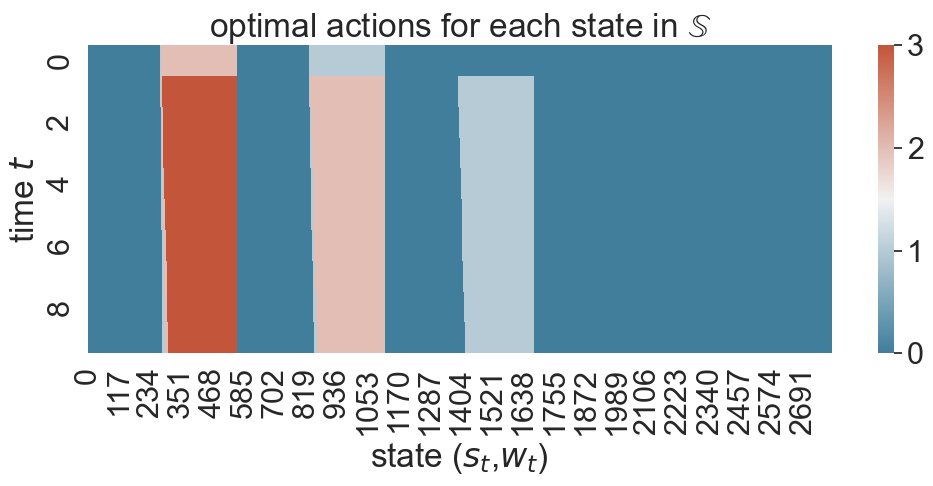

In [51]:
action_matrix = np.array([ optimal_actions_co[t] for t in optimal_actions_co ])
action_df = pd.DataFrame(action_matrix)

fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(action_df, cmap=cmap, ax=ax)
ax.set_xlabel(r'state ($s_t$,$w_t$)')
ax.set_ylabel(r'time $t$')
ax.set_title(f'optimal actions for each state in '+r'$\mathbb{S}$')

In [36]:
value_matrix = np.array([ value_functions_co[t] for t in value_functions_co ])
value_df = pd.DataFrame(value_matrix)
value_df

,0,1,2,3,4,5,6,7,8,9,...,2790,2791,2792,2793,2794,2795,2796,2797,2798,2799
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,8.041512,8.041512,8.041512,8.041512,8.041512,8.041512,8.041512,8.041512,8.041512,8.041512
2,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,13.253190,13.253190,13.253190,13.253190,13.253190,13.253190,13.253190,13.253190,13.253190,13.253190
3,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,16.949486,16.949486,16.949486,16.949486,16.949486,16.949486,16.949486,16.949486,16.949486,16.949486
4,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,20.474599,20.474599,20.474599,20.474599,20.474599,20.474599,20.474599,20.474599,20.474599,20.474599
5,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,23.984676,23.984676,23.984676,23.984676,23.984676,23.984676,23.984676,23.984676,23.984676,23.984676
6,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,27.493433,27.493433,27.493433,27.493433,27.493433,27.493433,27.493433,27.493433,27.493433,27.493433
7,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,31.002073,31.002073,31.002073,31.002073,31.002073,31.002073,31.002073,31.002073,31.002073,31.002073
8,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,34.510703,34.510703,34.510703,34.510703,34.510703,34.510703,34.510703,34.510703,34.510703,34.510703
9,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,38.019333,38.019333,38.019333,38.019333,38.019333,38.019333,38.019333,38.019333,38.019333,38.019333


## Cumulative Rewards

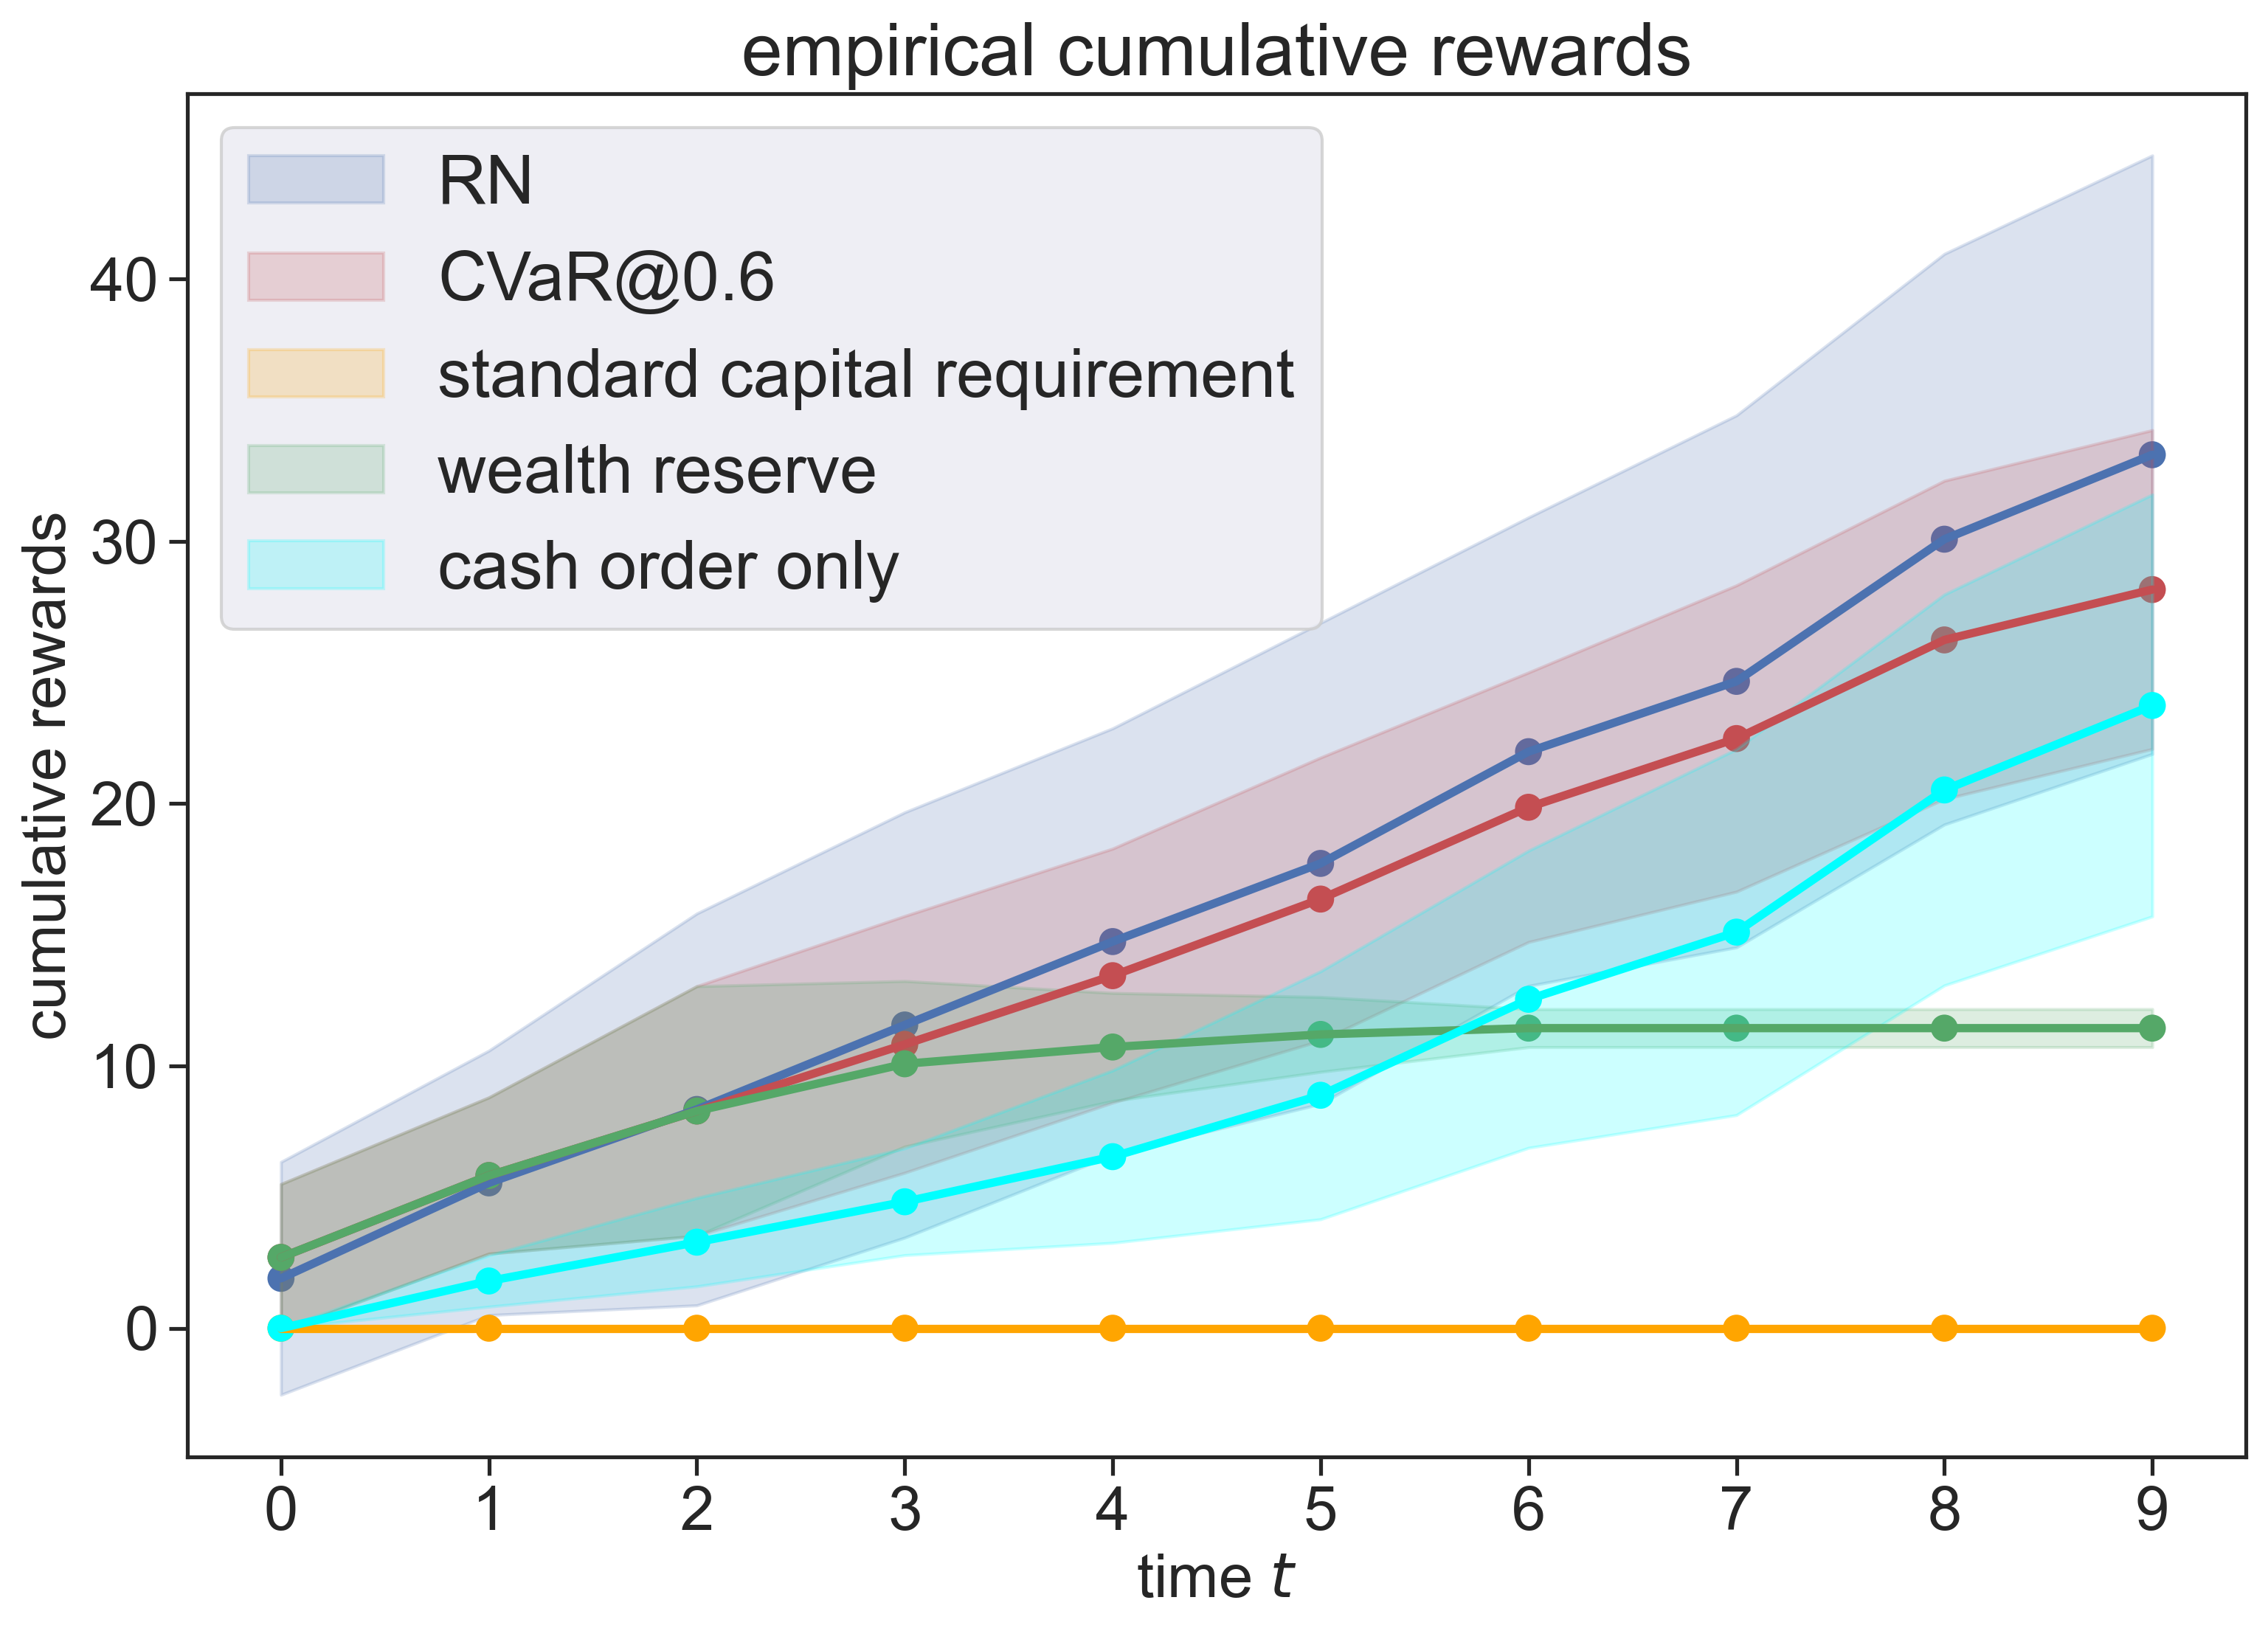

In [47]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set(font_scale=2)


CNT = 50
# generate random samples
np.random.seed(0)
s_rn_history = np.zeros(shape=(CNT,T))
a_rn_history = np.zeros(shape=(CNT,T))
r_rn_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_rn_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_rn_history[cnt, t]
        a_t = optimal_actions_RN[t][int(s_t)]
        r_rn_history[cnt, t] = r_t[int(s_t), a_t, xi_rn_history[t]]
        s_next = np.clip(s_t+a_t-xi_rn_history[t], a_min=0, a_max=max(S_space))
        a_rn_history[cnt, t] = a_t
        if t+1 <= T-1:
            s_rn_history[cnt, t+1] = s_next
            
r_rn_history_cumsum = r_rn_history.cumsum(axis=1)
r_rn_history_mean = r_rn_history_cumsum.mean(axis=0)
r_rn_history_std = r_rn_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_rn_history_mean, ax=ax, color='b', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_rn_history_mean-r_rn_history_std, y2=r_rn_history_mean+r_rn_history_std, 
                color='b', alpha=0.2, label='RN')


np.random.seed(0)
s_cvar_history = np.zeros(shape=(CNT,T))
a_cvar_history = np.zeros(shape=(CNT,T))
r_cvar_history = np.zeros(shape=(CNT,T))
for cnt in range(CNT):
    xi_cvar_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_cvar_history[cnt, t]
        a_t = optimal_actions_cvar[t][int(s_t)]
        r_cvar_history[cnt, t] = r_t[int(s_t), a_t, xi_cvar_history[t]]
        s_next = np.clip(s_t+a_t-xi_cvar_history[t], a_min=0, a_max=max(S_space))
        a_cvar_history[cnt, t] = a_t
        if t+1 <= T-1:
            s_cvar_history[cnt, t+1] = s_next
            
r_cvar_history_cumsum = r_cvar_history.cumsum(axis=1)
r_cvar_history_mean = r_cvar_history_cumsum.mean(axis=0)
r_cvar_history_std = r_cvar_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_cvar_history_mean, ax=ax, color='r', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_cvar_history_mean-r_cvar_history_std, y2=r_cvar_history_mean+r_cvar_history_std, 
                color='r', alpha=0.2, label=f'CVaR@{VAR_alpha}')


np.random.seed(0)
s_scr_history = np.zeros(shape=(CNT,T))
a_scr_history = np.zeros(shape=(CNT,T))
w_scr_history = np.zeros(shape=(CNT,T))
z_scr_history = np.zeros(shape=(CNT,T))
r_scr_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)
    
    t = 0
    s_t = s_scr_history[cnt, t]
    azw = optimal_actions_scr[t][int(s_t)]
    w_t, az = azw//(len(A_space)*len(Z_space))+w_bias, azw%(len(A_space)*len(Z_space))
    z_t, a_t = az//len(A_space), az%len(A_space)
    w_scr_history[cnt, t] = w_t
    a_scr_history[cnt, t] = a_t
    r_scr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
    
    s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
    w_next = np.clip(w_t-z_t, a_min=min(W_space), a_max=max(W_space))
    s_scr_history[cnt, t+1] = s_next
    w_scr_history[cnt, t+1] = w_next
    
    for t in range(1,T):
        s_t = s_scr_history[cnt, t]
        w_t = w_scr_history[cnt, t]
        az_t = optimal_actions_scr[t][int(s_t*len(W_space)+(w_t-w_bias))]
        z_t, a_t = az_t//len(A_space), az_t%len(A_space)
        a_scr_history[cnt, t] = a_t
        r_scr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t-z_t, a_min=min(W_space), a_max=max(W_space))
        
        if t+1 <= T-1:
            s_scr_history[cnt, t+1] = s_next
            w_scr_history[cnt, t+1] = w_next
            
r_scr_history_cumsum = r_scr_history.cumsum(axis=1)
r_scr_history_mean = r_scr_history_cumsum.mean(axis=0)
r_scr_history_std = r_scr_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_scr_history_mean, ax=ax, color='orange', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_scr_history_mean-r_scr_history_std, y2=r_scr_history_mean+r_scr_history_std, 
                color='orange', alpha=0.2, label=f'standard capital requirement')


np.random.seed(0)
s_wr_history = np.zeros(shape=(CNT,T))
a_wr_history = np.zeros(shape=(CNT,T))
w_wr_history = np.zeros(shape=(CNT,T))
z_wr_history = np.zeros(shape=(CNT,T))
r_wr_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_wr_history[cnt, t]
        w_t = w_wr_history[cnt, t]
        az_t = optimal_actions_wr[t][int(s_t*len(W_space)+(w_t-w_bias))]
        z_t, a_t = az_t//len(A_space), az_t%len(A_space)
        a_wr_history[cnt, t] = a_t
        r_wr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t+r_wr_history[cnt, t], a_min=min(W_space), a_max=max(W_space))
        
        if t+1 <= T-1:
            s_wr_history[cnt, t+1] = s_next
            w_wr_history[cnt, t+1] = w_next
            
r_wr_history_cumsum = r_wr_history.cumsum(axis=1)
r_wr_history_mean = r_wr_history_cumsum.mean(axis=0)
r_wr_history_std = r_wr_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_wr_history_mean, ax=ax, color='g', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_wr_history_mean-r_wr_history_std, y2=r_wr_history_mean+r_wr_history_std, 
                color= 'g', alpha=0.2, label=f'wealth reserve')




np.random.seed(0)
s_co_history = np.zeros(shape=(CNT,T))
a_co_history = np.zeros(shape=(CNT,T))
w_co_history = np.zeros(shape=(CNT,T))
z_co_history = np.zeros(shape=(CNT,T))
r_co_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_co_history[cnt, t]
        w_t = w_co_history[cnt, t]
        a_t = optimal_actions_co[t][int(s_t*len(W_space)+(w_t-w_bias))]
        a_co_history[cnt, t] = a_t
        r_co_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t+r_co_history[cnt, t], a_min=min(W_space), a_max=max(W_space))

        if t+1 <= T-1:
            s_co_history[cnt, t+1] = s_next
            w_co_history[cnt, t+1] = w_next
            
r_co_history_cumsum = r_co_history.cumsum(axis=1)
r_co_history_mean = r_co_history_cumsum.mean(axis=0)
r_co_history_std = r_co_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_co_history_mean, ax=ax, color='cyan', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_co_history_mean-r_co_history_std, y2=r_co_history_mean+r_co_history_std, 
               color= 'cyan', alpha=0.2, label=f'cash order only')


ax.set_title('empirical cumulative rewards')
ax.legend()
ax.set_xlabel(r'time $t$', fontsize=20)
ax.set_ylabel('cumulative rewards', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

In [48]:
w_scr_history[:,0]

array([-2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.])

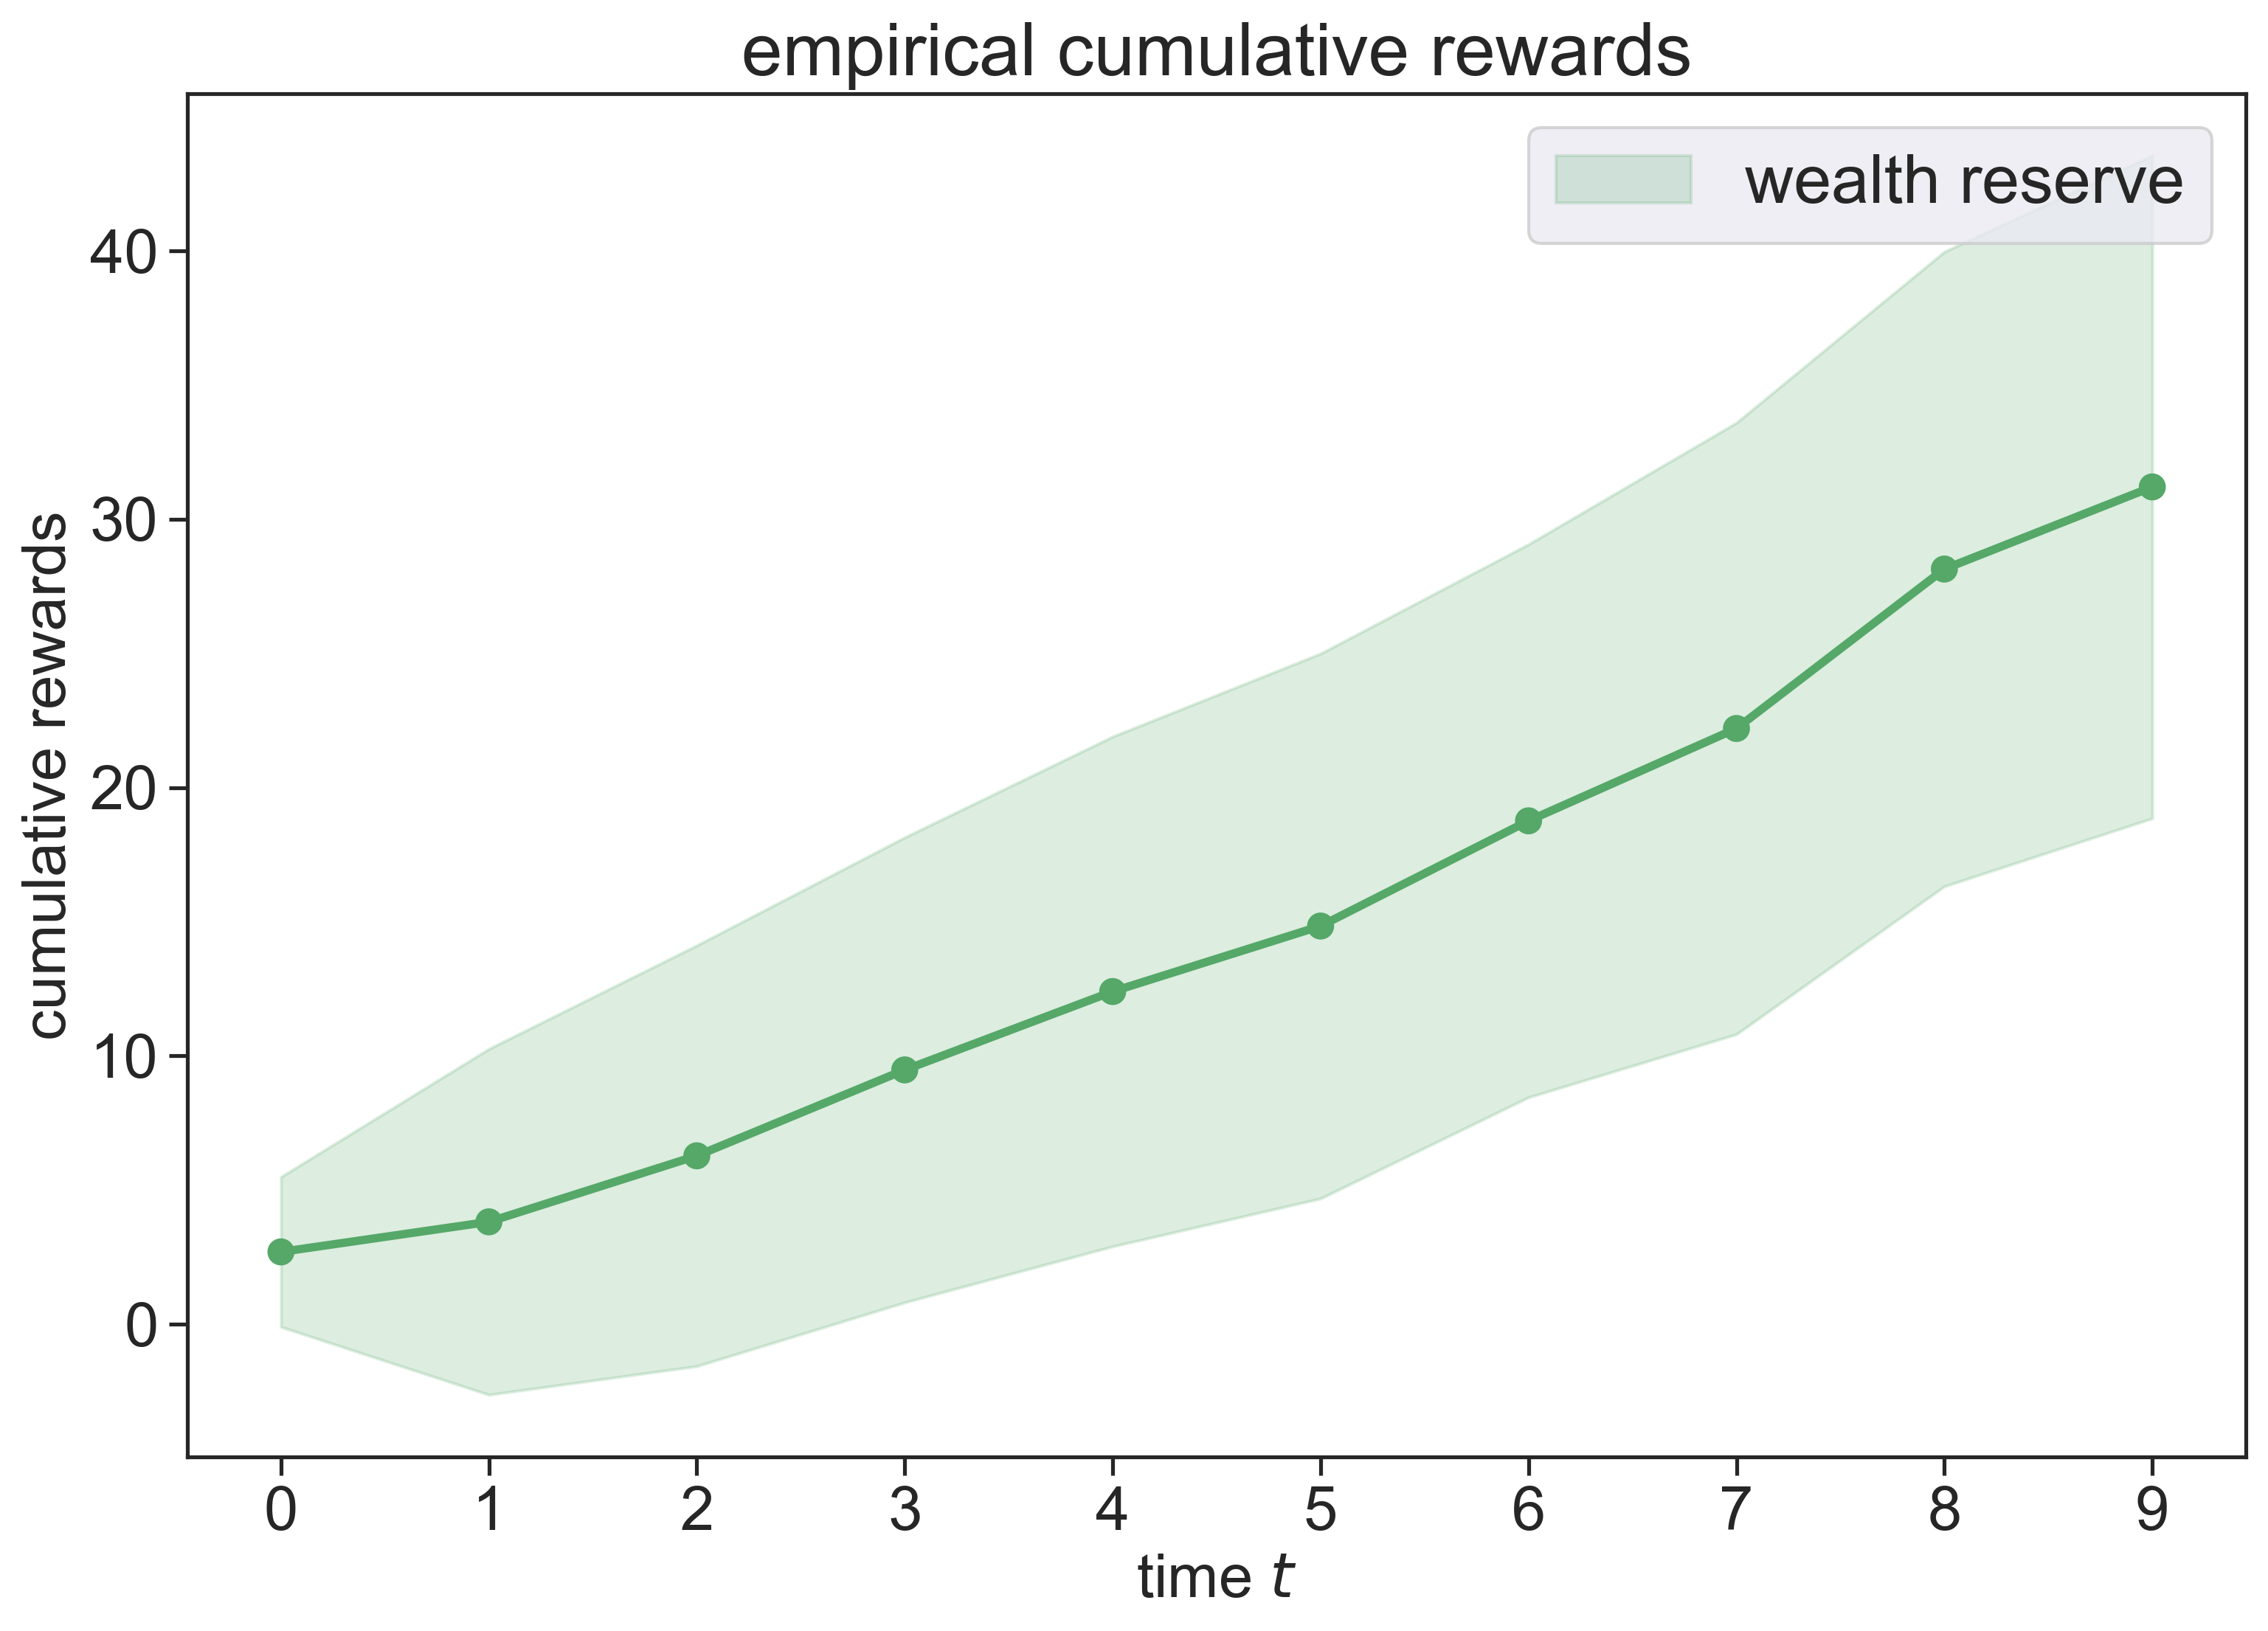

In [38]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
sns.set(font_scale=2)


CNT = 50


np.random.seed(0)
s_scr_history = np.zeros(shape=(CNT,T))
a_scr_history = np.zeros(shape=(CNT,T))
w_scr_history = np.zeros(shape=(CNT,T))
z_scr_history = np.zeros(shape=(CNT,T))
r_scr_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)
    
    t = 0
    s_t = s_scr_history[cnt, t]
    azw = optimal_actions_scr[t][int(s_t)]
    w_t, az = azw//(len(A_space)*len(Z_space))+w_bias, azw%(len(A_space)*len(Z_space))
    z_t, a_t = az//len(A_space), az%len(A_space)
    a_scr_history[cnt, t] = a_t
    r_scr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
    
    s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
    w_next = np.clip(w_t+w_bias-z_t, a_min=min(W_space), a_max=max(W_space))
    s_scr_history[cnt, t+1] = s_next
    w_scr_history[cnt, t+1] = w_next
    
    for t in range(1,T):
        s_t = s_scr_history[cnt, t]
        w_t = w_scr_history[cnt, t]
        az_t = optimal_actions_scr[t][int(s_t*len(W_space)+(w_t-w_bias))]
        z_t, a_t = az_t//len(A_space), az_t%len(A_space)
        a_scr_history[cnt, t] = a_t
        r_scr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t+w_bias-z_t, a_min=min(W_space), a_max=max(W_space))
        
        if t+1 <= T-1:
            s_scr_history[cnt, t+1] = s_next
            w_scr_history[cnt, t+1] = w_next
            
r_scr_history_cumsum = r_scr_history.cumsum(axis=1)
r_scr_history_mean = r_scr_history_cumsum.mean(axis=0)
r_scr_history_std = r_scr_history_cumsum.std(axis=0)

# sns.pointplot(x=np.arange(T), y=r_scr_history_mean, ax=ax, color='orange', alpha=0.5)
# ax.fill_between(x=np.arange(T), y1=r_scr_history_mean-r_scr_history_std, y2=r_scr_history_mean+r_scr_history_std, 
#                 color='orange', alpha=0.2, label=f'standard capital requirement')


np.random.seed(0)
s_wr_history = np.zeros(shape=(CNT,T))
a_wr_history = np.zeros(shape=(CNT,T))
w_wr_history = np.zeros(shape=(CNT,T))
z_wr_history = np.zeros(shape=(CNT,T))
r_wr_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_wr_history[cnt, t]
        w_t = w_wr_history[cnt, t]
        az_t = optimal_actions_wr[t][int(s_t*len(W_space)+(w_t-w_bias))]
        z_t, a_t = az_t//len(A_space), az_t%len(A_space)
        a_wr_history[cnt, t] = a_t
        r_wr_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t+w_bias+r_wr_history[cnt, t], a_min=min(W_space), a_max=max(W_space))
        
        if t+1 <= T-1:
            s_wr_history[cnt, t+1] = s_next
            w_wr_history[cnt, t+1] = w_next
            
r_wr_history_cumsum = r_wr_history.cumsum(axis=1)
r_wr_history_mean = r_wr_history_cumsum.mean(axis=0)
r_wr_history_std = r_wr_history_cumsum.std(axis=0)

sns.pointplot(x=np.arange(T), y=r_wr_history_mean, ax=ax, color='g', alpha=0.5)
ax.fill_between(x=np.arange(T), y1=r_wr_history_mean-r_wr_history_std, y2=r_wr_history_mean+r_wr_history_std, 
                color= 'g', alpha=0.2, label=f'wealth reserve')




np.random.seed(0)
s_co_history = np.zeros(shape=(CNT,T))
a_co_history = np.zeros(shape=(CNT,T))
w_co_history = np.zeros(shape=(CNT,T))
z_co_history = np.zeros(shape=(CNT,T))
r_co_history = np.zeros(shape=(CNT,T))

for cnt in range(CNT):
    xi_history = np.random.choice(XI_space, T, p=prob)

    for t in range(T):
        s_t = s_co_history[cnt, t]
        w_t = w_co_history[cnt, t]
        a_t = optimal_actions_co[t][int(s_t*len(W_space)+(w_t-w_bias))]
        a_co_history[cnt, t] = a_t
        r_co_history[cnt, t] = r_t[int(s_t), a_t, xi_history[t]]
        
        s_next = np.clip(s_t+a_t-xi_history[t], a_min=0, a_max=max(S_space))
        w_next = np.clip(w_t+w_bias+r_co_history[cnt, t], a_min=min(W_space), a_max=max(W_space))

        if t+1 <= T-1:
            s_co_history[cnt, t+1] = s_next
            w_co_history[cnt, t+1] = w_next
            
r_co_history_cumsum = r_co_history.cumsum(axis=1)
r_co_history_mean = r_co_history_cumsum.mean(axis=0)
r_co_history_std = r_co_history_cumsum.std(axis=0)

# sns.pointplot(x=np.arange(T), y=r_co_history_mean, ax=ax, color='cyan', alpha=0.5)
# ax.fill_between(x=np.arange(T), y1=r_co_history_mean-r_co_history_std, y2=r_co_history_mean+r_co_history_std, 
#                color= 'cyan', alpha=0.2, label=f'cash order only')


ax.set_title('empirical cumulative rewards')
ax.legend()
ax.set_xlabel(r'time $t$', fontsize=20)
ax.set_ylabel('cumulative rewards', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

In [39]:
a_scr_history, w_scr_history

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
